In [4]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using : cuda


### Parsing Naïve TCR db


In [5]:
epitope_map = {
    "ELAGIGILTV" : 1 #Melanoma MLANA
    ,"GILGFVFTL"  : 0 #Influenza A M gene
    ,"SLFNTVATLY" : 0 #HIV
    ,"RMFPNAPYL" : 1 #WT1
    ,"LLDFVRFMGV" : 1 #EBNA-B EBV but also linked to 
    ,"GLCTLVAML" : 1 #BMLF1 ebv
    ,"LLFGYPVYV" : 0 #HTLV-1 Tax
    ,"SLLMWITQV" : 1 #well known squamous cell NY-ESO
    ,"FLYALALLL" : 1 #EBV LMP2A, but linked to lymphoma
    ,"FLASKIGRLV" : 0 # PLA2G6 phospholipase
    ,"MLDLQPETT" : 1 #HPV E7
    ,"IMDQVPFSV" : 1 #PMEL melanosome....
    ,"YLLEMLWRL" : 1 #EBV lmp1 viral oncogene
    ,"KVLEYVIKV" : 1 #MAGE A1
    ,"RTLNAWVKV" : 0 #HIV gag1
    ,"KTWGQYWQV" : 1 #PMEL
    ,"YLNDHLEPWI" : 1 #BCL-2-l1
    ,"SLFNTVATL" : 0 #HIV Gag 1
    ,"CLLWSFQTSA" : 0 #tyr (ALBINISM)
    ,"ILKEPVHGV" : 0 #HIV1 POL
    ,"CLLGTYTQDV" : 0 #KANAMYCYN KANJ (ANTIBIO)
    ,"NLVPMVATV" :  0 #H CMV
    ,"KLQCVDLHV" : 0 # klk3
    ,"ELAGIGLTV" : 1 #MLANA
    ,"VLEETSVML" : 0 #CMV IE1
    ,"YVLDHLIVV" :  0 #HPV brlf1
    ,"FLGKIWPSHK" : 0 # HIV gag1
    ,'KVAELVHFL' : 1 #melanoma associated antigen 9
    ,"CLNEYHLFL" : 0 # human NDC1
    ,"AMFWSVPTV" : 0 #TKT phosphate glycolysis 
    ,"FLYNLLTRV" :  0 #SEC24A
    ,"KLMNIQQKL" : 1 #AKAP13
    ,"IILVAVPHV" : 0 #EXOC8
    ,"MLGEQLFPL" : 0 #PABPC1
    ,"YILEETSVM" : 0 # CMV IE1
    ,"CINGVCWTV" :  1 #NS3 Hep C??
    ,"KLSALGINAV" : 1 #NS3 Hep C??
    ,"LLWNGPMAV" :  1 #NS4B Hep C??
    ,"TLNAWVKVV" : 0 #HIV GAG1
    ,"KINAWIKVV" : 0 #HIV gag
    ,"SLYNTVATL" : 0 #HIV gag
    ,"CVNGSCFTV" : 0 #Influenza A
    ,"ARNLVPMVATVQGQN" : 0 #pp65
    ,"LSEFCRVLCCYVLEE" : 0 #CMV IE1
    ,"LLFGYAVYV" : 0 # HLTV tax
    ,"LLFGYPRYV" : 0 #HLTV tax
    ,"SLLMWITQC" : 1 #NY-ESO-1
    ,"LLFGKPVYV" : 0 #HLTV tax
    ,"LLFGPVYV" : 0 #HLTV tax
    ,"MLWGYLQYV" : 0 #HLTV tax
    ,"LGYGFVNYI" : 0 #TAX
    ,"AAGIGILTV" : 1 #MLANA
    ,"LLFGFPVYV" : 0 #tax
    ,"ALWGPDPAAA" : 0 #Insuline INS
    ,"ELAAIGILTV" : 1 #MLANA
    ,"ELAGIGALTV" : 1 #MLANA
    ,"ILAKFLHWL" : 1 #TERT
    ,"EAAGIGILTV" : 1 # MLANA
    ,"LLFGYPVAV" : 0 #Tax HTLV
    ,"ALGIGILTV" : 1 #MLANA
    ,"LLLGIGILV" : 0 #BST2
    ,"KLVALGINAV" : 1 #NS3 hepc
    ,"CLGGLLTMV" : 1 #LMP2A
    ,"NLSALGIFST" : 0#IGF2BP2
    ,"MLNIPSINV" :0#pp65
    ,"VAANIVLTV" : 0#SLC30A8
    ,'SLYNTVATLY':0 #HIV gag
}

In [6]:
AAs= ['A','R','N','D','B','C','E','Q','Z','G',
'H','I','L','K','M','F','P','S','T','W','Y','V']
def filter_df(df, v = False):
    df = df.dropna(subset=['amino_acid'])\
           .query('amino_acid.str.len()>=12 & amino_acid.str.len()<=16')\
           .query("amino_acid.str.startswith('C') & amino_acid.str.endswith('F')")\
           .query('not amino_acid.str.contains("\*")')\
           .query('not amino_acid.str.contains("\~")')
    df['len'] = df.amino_acid.str.len()
    df.drop_duplicates(subset='amino_acid',inplace=True)
    return df

#manual 1hot encode lol
AA_KEYS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_to_int = dict((c,i) for i,c in enumerate(AA_KEYS))
int_to_char = dict((i,c) for i,c in enumerate(AA_KEYS))

def onehot_aa(seq):
    int_encoded = [char_to_int[char] for char in seq]
    onehot_encoded = list()
    for value in int_encoded:
        letter = [0 for _ in range(len(AA_KEYS))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()

from sklearn.decomposition import PCA 

def get_reduc(df, n=3):#, top=100):
    #Getting onehot features for PCA
    pca = PCA(n_components=n)
    tmp = df.copy()
    X = np.array([x for x in df['oh']])
    print(X.shape, type(X))
    comp = pca.fit_transform(X)
    print("Explained var ratios :",pca.explained_variance_ratio_)
    print("Explained var : ",pca.explained_variance_)
    for i in range(n):
        tmp['PCA'+str(i+1)]=comp[:,i]
    var_ratio = pca.explained_variance_ratio_.tolist()
    var_ratio = ['{:g}'.format(float('{:.3g}'.format(i))) for i in var_ratio]
    tmp['var_ratios'] = [var_ratio for _ in range(len(tmp))]
    return tmp

def get_pca(df,n=3):
    df = df.copy()
    df['oh'] = df['amino_acid'].apply(onehot_aa)
    output = get_reduc(df,n)
    return output


In [12]:
naive_db = pd.read_csv('../training_data_new/training_data_curated/db_TRB.csv',
                       header=0, usecols = ['cdr3_TRB','TRBV','TRBJ'])
naive_db.rename(columns={'cdr3_TRB':'amino_acid'},inplace=True)
filtered_db = filter_df(naive_db)
filtered_db.to_csv('filtered_naive_db.csv', header=True, index=False)

In [13]:
filtered_db.sample(3)

amino_acid      TRBV     TRBJ  len
4495483  CASSLAAGNSNQPQHF   TRBV7-6  TRBJ1-5   16
3903125     CASSSGRPYGYNF  TRBV12-3  TRBJ1-2   13
4558961    CASSYEVSSYGYTF   TRBV6-2  TRBJ1-2   14

##### Aim : Try to sample an unbiased training dataset. 
To do so, try to have as many combinations of TRBV and TRBJ and each sequence so the dataset is not biased towards anything

In [69]:
from itertools import product
from tqdm import tqdm
import math
#Getting combinations of TRBV-J
trbv = filtered_db.TRBV.unique()
trbj = filtered_db.TRBJ.unique()
combo = product(trbv,trbj)
#result df
sample_df = pd.DataFrame()
i=0
total = 832
for V,J in combo:  
    print('{:.2%} done'.format(i), end='\r')
    i+=1/total
    #getting subset
    sub = filtered_db.query('TRBV==@V and TRBJ==@J')
    if len(subset)==0:
        continue
    else : 
        for l in range(12,17):#For each length,
            tmp = sub.query('len==@l')
            n = math.floor(0.1*len(tmp))
            sample_df=sample_df.append(tmp.sample(n),ignore_index=True)

In [331]:
filter_df(sample_df[['amino_acid','TRBV','TRBJ','len']]).to_csv('sampled_10p_naive_db.csv', header=True, index=False)

##### After sampling, checking sequences with PCA 

In [374]:
#sample_df['oh'] = sample_df['amino_acid'].apply(onehot_aa)
naive_12 = get_pca(sample_df.query('len==12'))
naive_13 = get_pca(sample_df.query('len==13'))
naive_14 = get_pca(sample_df.query('len==14'))
naive_15 = get_pca(sample_df.query('len==15'))
naive_16 = get_pca(sample_df.query('len==16'))

In [189]:
sns.set_palette('cubehelix')
ll = 12
for df in [naive_12, naive_13, naive_14, naive_15, naive_16]:
    pca_plot(df, 'Naive')
    plt.close()
    ll+=1


### Checking tumor datasets 18.02.21

### McPas and DB_pos

In [44]:
sample_df = pd.read_csv('../training_data_new/training_data_curated/sampled_10p_naive_db.csv')

In [30]:
mcpas = pd.read_csv('../new_data/McPas-TCR.csv', 
                    usecols = ['CDR3.beta.aa', 'Species', 'Category', 'Epitope.peptide', 
                               'Epitope.ID', 'MHC','Tissue','TRBV', 'TRBD', 'TRBJ'])\
          .rename(columns={'CDR3.beta.aa':'amino_acid'})\
          .query('Species=="Human"')
mcpas = filter_df(mcpas)
mcpas['label'] = mcpas.apply(lambda x : 1 if x['Category'] == 'Cancer' else 0, axis=1)

db_pos = pd.read_csv('../new_data/db_pos.csv',usecols = ['epitope','cdr3_TRB','TRBV','TRBJ'])\
           .rename(columns={'cdr3_TRB':'amino_acid'})
db_pos = filter_df(db_pos)
db_pos['label'] =db_pos['epitope'].apply(lambda x: epitope_map[x])

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,13,14,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [300]:
a = len(db_pos.query('label==1'))+len(mcpas.query('label==1'))
x= pd.concat([db_pos.query('label==1')[['amino_acid']],mcpas.query('label==1')[['amino_acid']]])
len(x.amino_acid.unique()), len(db_pos.query('label==1')),len(mcpas.query('label==1'))

(4281, 2609, 1704)

Models & weights loaded
Getting data
Data device = cpu
Done loading, returning features and labels.


(<Figure size 4320x2880 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'ROC_AUC on test set for L = 12, total 3182 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 13, total 6412 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 14, total 8481 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>],
        [<AxesSubplot:title={'center':'ROC_AUC on test set for L = 15, total 7040 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 16, total 2846 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:>]], dtype=object))

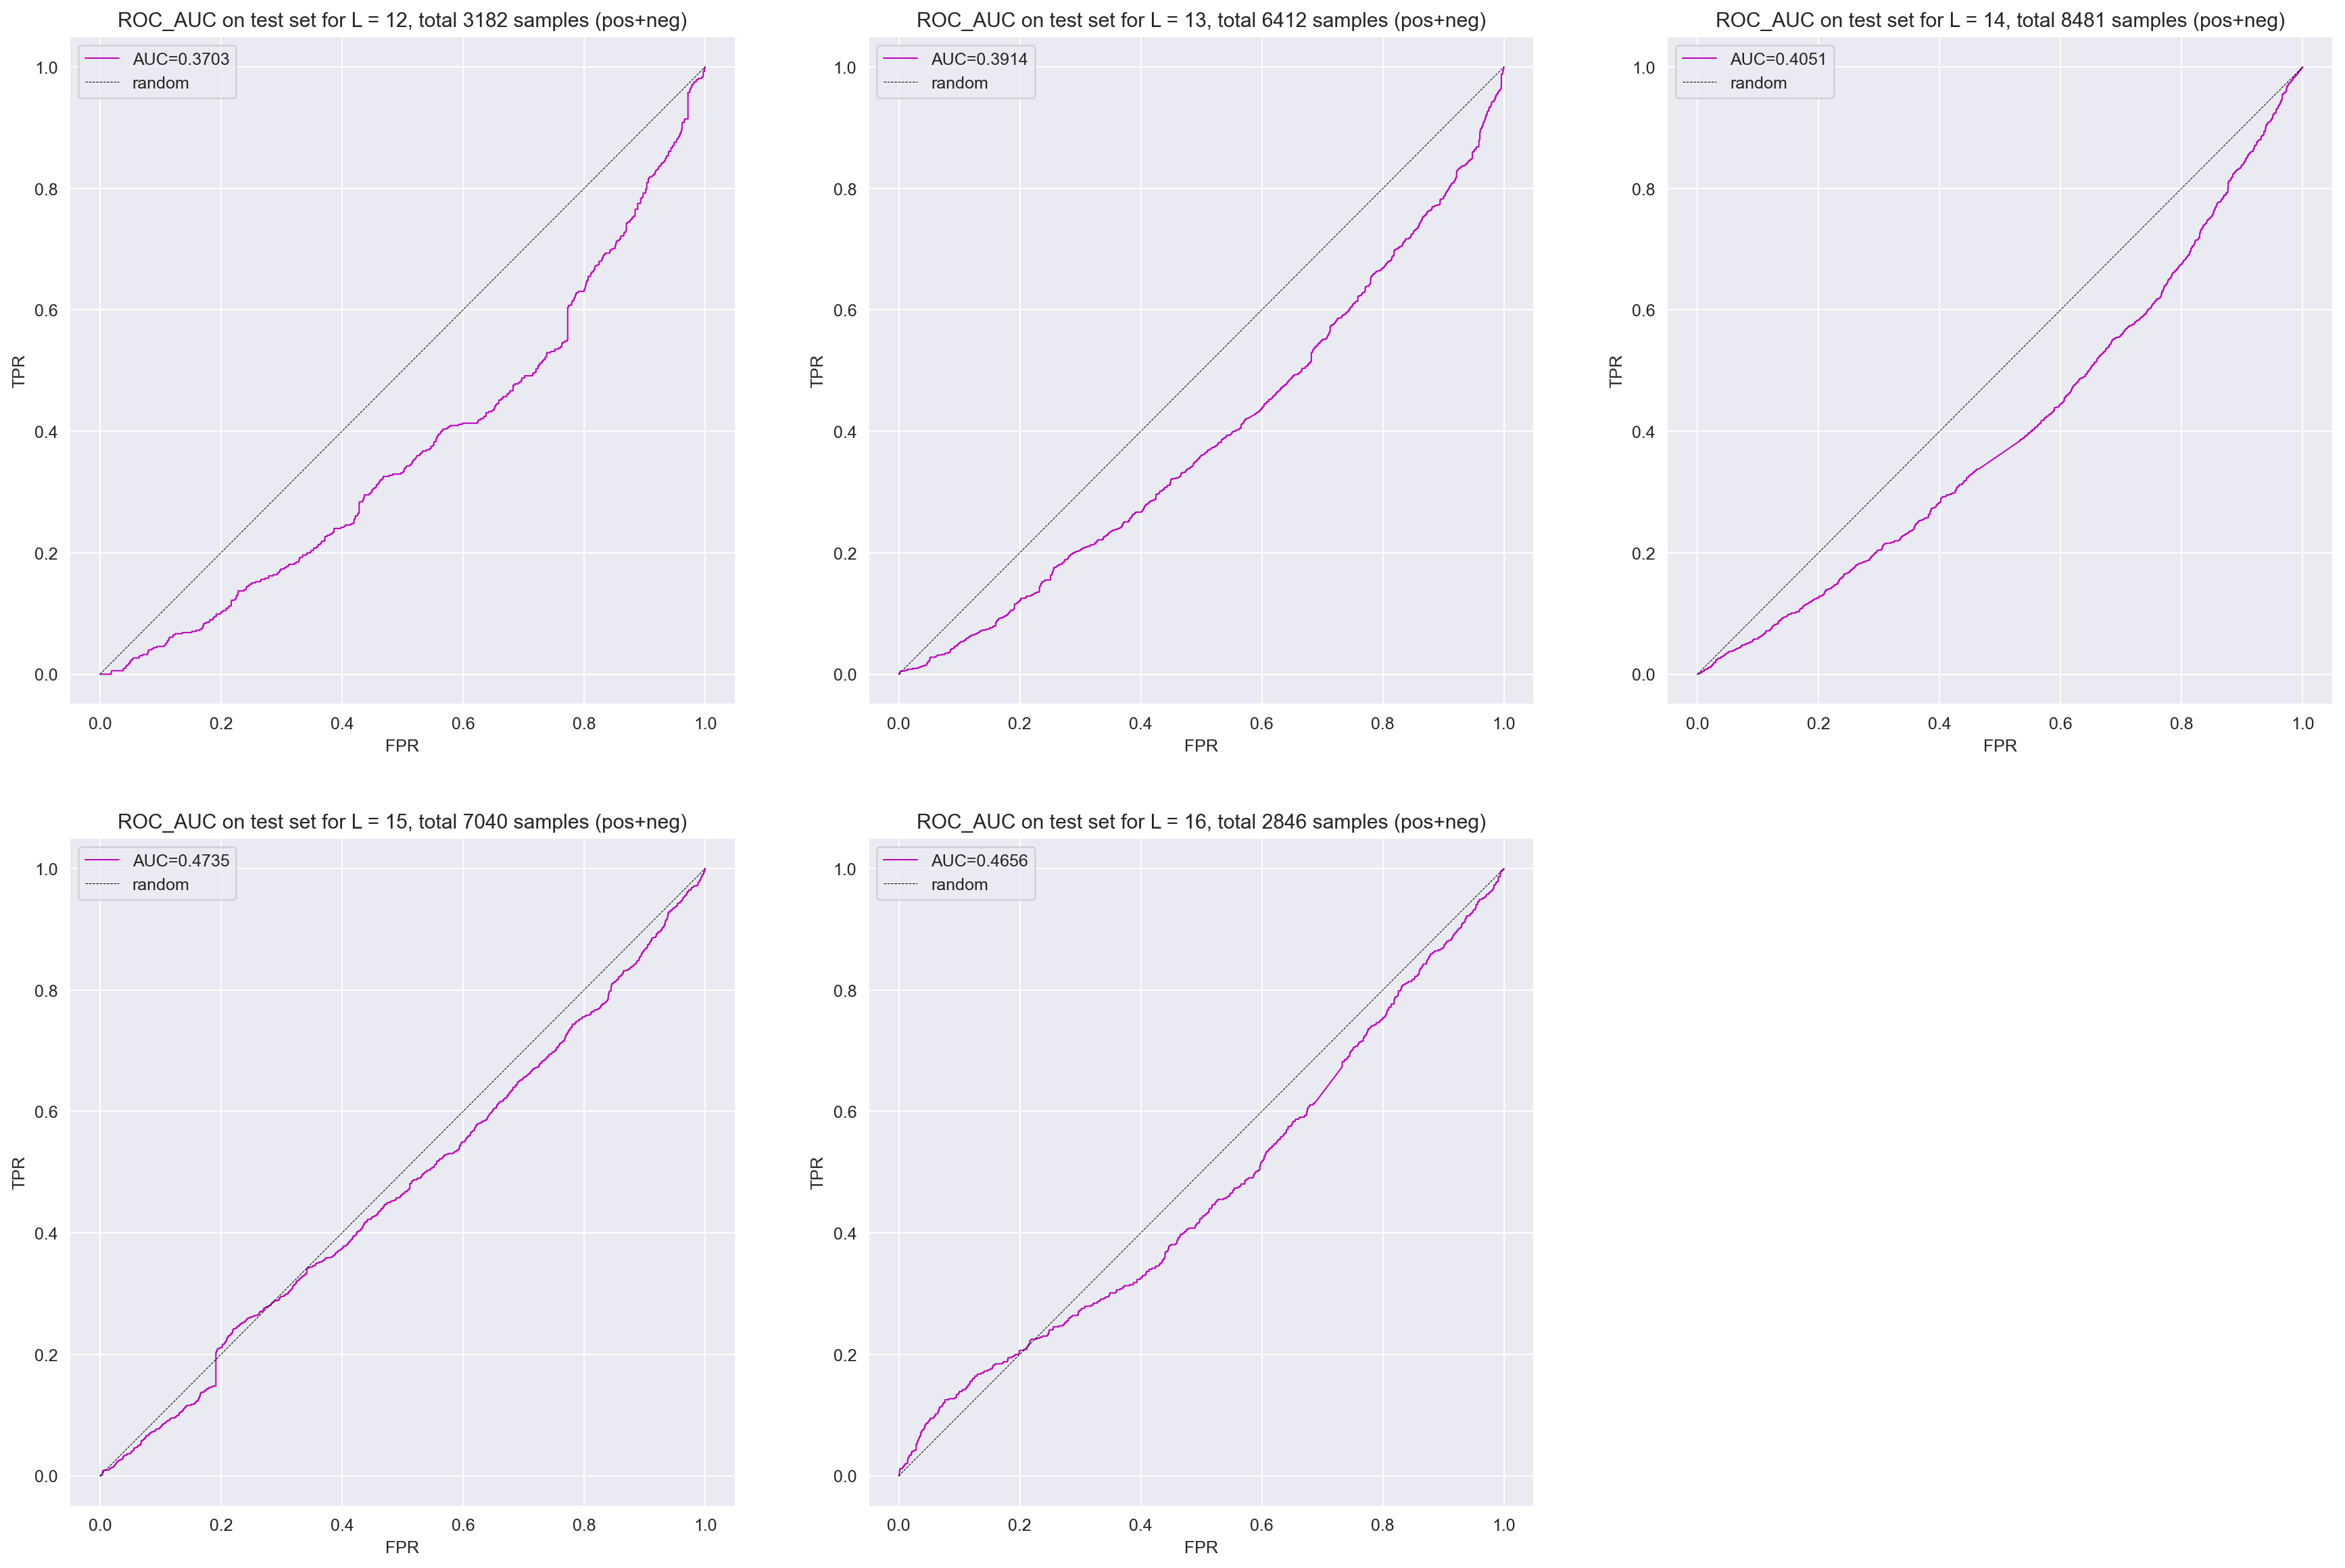

In [151]:
models = load_models('../output/training_output/richie_minmax_filtered',
                     arch = 'richie', eval_ = True)
control_aa = sample_df.sample(math.ceil(a*4)).amino_acid.values
tumor_aa = np.append(mcpas.query('label==1')['amino_acid'].values,
                     db_pos.query('label==1')['amino_acid'].values)
features, labels = generate_features_labels(tumor_aa, control_aa, 
                                            encoding='aa_atchley',
                                            scaling='minmax', shuffle=True)

_, accs, aucs, f1s, curves = test_eval(models, features, labels, return_curve=True)
df=get_pred_df(models,features,labels)
plot_roc_curve(curves, save=None)

##### Tumor sequences from DeepCAT initial dataset

In [420]:
#These come from the initial (filtered) training set from Beshnova
train_tumor = pd.read_csv('../training_data_filtered/TumorCDR3_filtered.txt').rename(columns={'amino_acids':'amino_acid'})
test_tumor = pd.read_csv('../training_data_filtered/TumorCDR3_test.txt', header=None).rename(columns={0:'amino_acid'})
tumor_set_og = pd.concat([train_tumor,test_tumor]).reset_index(drop=True)
tumor_set_og.drop_duplicates(inplace=True)
tumor_set_og['len']=tumor_set_og.amino_acid.str.len()

tumor_set_agg = pd.concat([db_pos.query('label==1')[['amino_acid']], 
                           mcpas.query('label==1')[['amino_acid']]],).reset_index(drop=True)
tumor_set_agg.drop_duplicates(inplace=True)
tumor_set_agg['len']=tumor_set_agg.amino_acid.str.len()


### Adaptive Biotech : Merkel Cell Carcinoma dataset


In [32]:
P = '../new_data/mcc/'

_Human CD4+ T cells specific for Merkel cell polyomavirus localize to Merkel cell carcinomas and target a required oncogenic domain_

In [228]:
cd4 = pd.DataFrame()
for file in os.listdir(P+'CD4/'):
    if '.tsv' not in file:continue
    fn = os.path.join(P+'CD4/',file)
    temp = filter_df(pd.read_csv(fn, sep='\t', header=0, 
                       usecols = ['sample_name','locus', 'v_gene', 
                                  'j_gene','cdr3_amino_acid'])\
             .rename(columns={'cdr3_amino_acid':'amino_acid'}))
    cd4 = cd4.append(temp,ignore_index=True)
cd4

_CD8+ TIL Patient biopsies. All tumoral_

In [36]:
mcc_biopsy = filter_df(pd.read_csv(P+'pf16-009_z1233_MCC_Biopsy_survey_TCRB.tsv', sep='\t', header=0,
                        usecols = ['sample_name','locus', 'v_gene',
                                    'j_gene','cdr3_amino_acid']).rename(columns={'cdr3_amino_acid':'amino_acid'}))
mcc_biopsy.head()

sample_name locus      v_gene      j_gene  \
1  pf16-009_z1233_MCC_Biopsy_survey_TCRB  TCRB  TCRBV06-06  TCRBJ01-02   
2  pf16-009_z1233_MCC_Biopsy_survey_TCRB  TCRB  TCRBV06-06  TCRBJ02-03   
3  pf16-009_z1233_MCC_Biopsy_survey_TCRB  TCRB  TCRBV06-06  TCRBJ02-03   
4  pf16-009_z1233_MCC_Biopsy_survey_TCRB  TCRB  TCRBV06-06  TCRBJ02-02   
5  pf16-009_z1233_MCC_Biopsy_survey_TCRB  TCRB  TCRBV06-06  TCRBJ02-07   

         amino_acid  len  
1    CASSVLQGWNGYTF   14  
2  CASSYIASGGADTQYF   16  
3      CASSYEEGQKYF   12  
4    CASSVLDFAGELFF   14  
5     CASSKGGSYEQYF   13

**Farah-Tetzlaff**

The integrity of the immune system represents a pivotal risk factor and prognostic biomarker for Merkel cell
carcinoma. A higher density of tumor-associated T cells correlates with improved Merkel cell
carcinomaespecific survival, but the prognostic importance of the T-cell infiltrate reactivity is unknown.***

We
evaluated the T-cell receptor repertoire associated with 72 primary Merkel cell carcinomas[...]  These correlations were mostly preserved in the Merkel cell
polyomavirusenegative subgroup. Combining SDom with CD3þ or CD8þ T-cell density revealed three distinct
prognostic groups with respect to disease-specific survival. Patients with both high SDom and high CD3þ or
CD8þ T-cell density had markedly improved disease-specific survival compared with patients with low SDom
and low CD3þ or CD8þ T-cell density (P ¼ 0.002 and P ¼ 0.03, respectively). ... Our findings demonstrate that the quality of the
tumor-associated T-cell infiltrate informs patient prognosis in primary Merkel cell carcinoma beyond the T-cell
density.


In [231]:
#Repertoires! 
farah_tetzlaff = pd.DataFrame()
for file in os.listdir(P+'farah_tetzlaff/'):
    if '.tsv' not in file:continue
    fn = os.path.join(P+'farah_tetzlaff/',file)
    temp = filter_df(pd.read_csv(fn, sep='\t', header=0, 
                       usecols = ['sample_name','locus', 'v_gene', 
                                  'j_gene','cdr3_amino_acid'])\
             .rename(columns={'cdr3_amino_acid':'amino_acid'}))
    farah_tetzlaff = farah_tetzlaff.append(temp,ignore_index=True)
farah_tetzlaff

sample_name locus      v_gene      j_gene        amino_acid  len
0                 1  TCRB  TCRBV05-01  TCRBJ01-01     CASSLGANTEAFF   13
1                 1  TCRB  TCRBV05-01  TCRBJ02-05   CASSRGLAREETQYF   15
2                 1  TCRB  TCRBV01-01  TCRBJ01-02  CTSRCYSLRKTYGYTF   16
3                 1  TCRB  TCRBV30-01  TCRBJ01-02      CAWRDGEYGYTF   12
4                 1  TCRB  TCRBV30-01  TCRBJ01-03   CAWRTRGGSGNTIYF   15
...             ...   ...         ...         ...               ...  ...
172900           72  TCRB         NaN  TCRBJ02-05     CSARAQGFQTQYF   13
172901           72  TCRB         NaN  TCRBJ02-07    CSARESSGNVEQYF   14
172902           72  TCRB         NaN  TCRBJ01-04    CASSQPGQTEKLFF   14
172903           72  TCRB         NaN  TCRBJ01-05  CASSLGAAYSNQPQHF   16
172904           72  TCRB         NaN  TCRBJ01-01   CSASPQAGVNTEAFF   15

[172905 rows x 6 columns]

**PBMC**.

_Heparinized blood was obtained from MCC patients, and
peripheral blood mononuclear cells (PBMC) were cryopreserved
after routine Ficoll preparation at a dedicated specimen processing facility at FHCRC._


**Patient Tumors**. 

_When available, fresh MCC tumor material from
core and/or punch biopsy samples were processed and TIL cultured for 2 weeks before analysis as described (17). For excised
tumors of larger volume (>1 cm3
), the remaining tissue was
digested as described (18), and single-cell suspensions were
cryopreserved._


In [33]:
# Those all come from MCC tumor patients, either PBMC or TILs
def filter_name(df):
    if 'tumor' in df['sample_name'] or 'TIL' in df['sample_name']: return 'tumor'
    if 'PBMC' in df['sample_name']: return 'pbmc'
    if 'LN' in df['sample_name'] :return 'ln'
kll = pd.DataFrame()
for file in os.listdir(P+'KLL/'):
    if '.tsv' not in file:continue
    fn = os.path.join(P+'KLL/',file)
    temp = pd.read_csv(fn, sep='\t', header=0, 
                       usecols = ['sample_name','locus', 'v_gene', 
                                  'j_gene','amino_acid'])\
             #.rename(columns={'cdr3_amino_acid':'amino_acid'})
    kll = kll.append(temp,ignore_index=True)
    kll = filter_df(kll)
kll['type']=kll.apply(filter_name,axis=1)
kll.head()

sample_name locus        amino_acid      v_gene      j_gene  len  \
0  w1045_PBMC_KLL_Tet+  TCRB   CASSQQSSRTDTQYF  TCRBV07-09  TCRBJ02-03   15   
1  w1045_PBMC_KLL_Tet+  TCRB    CASKGVRKTYGYTF  TCRBV05-02  TCRBJ01-02   14   
2  w1045_PBMC_KLL_Tet+  TCRB  CASSTRVPQGNTEAFF  TCRBV19-01  TCRBJ01-01   16   
3  w1045_PBMC_KLL_Tet+  TCRB    CASSLMGVSETQYF  TCRBV19-01  TCRBJ02-05   14   
4  w1045_PBMC_KLL_Tet+  TCRB   CASRAALGSNQPQHF  TCRBV19-01  TCRBJ01-05   15   

   type  
0  pbmc  
1  pbmc  
2  pbmc  
3  pbmc  
4  pbmc

In [37]:
mcc_tumor = filter_df(pd.concat([kll.query('type=="tumor"'), mcc_biopsy]))
mcc_tumor.to_csv('mcc_curated_tumor_or_tils.csv')

### After filtering MCC, get train and test for tumor and naïve

In [356]:
shuffled = mcc_tumor.sample(frac=1).reset_index(drop=True)
third = math.floor(len(shuffled)/3)
test = shuffled[0:third]
test.to_csv('TumorCDR3_MCC_test.txt', index=False, header=False, columns=['amino_acid'])
train = shuffled[third:-1]
train.to_csv('TumorCDR3_MCC.txt', index=False, header=False, columns=['amino_acid'])


In [357]:
test.to_csv('Tumor_MCC_curated_test.csv')#, columns=['amino_acid'])

train.to_csv('Tumor_MCC_curated.csv')#, columns=['amino_acid'])


In [336]:
len(train), len(test)

(12735, 6367)

### Subsampling naive set

In [349]:
from itertools import product
trbv = sample_df.TRBV.unique()
trbj = sample_df.TRBJ.unique()
sample_df = filter_df(sample_df)
combo = product(trbv,trbj)
#result df
i=0
total = 754
naive_train = pd.DataFrame()
naive_test = pd.DataFrame()
for V,J in combo:  
    print('{:.2%} done'.format(i), end='\r')
    i+=1/total
    #Sampling combo and shuffling
    sub = sample_df.query('TRBV==@V and TRBJ==@J').sample(frac=1)
    for l in range(12,17):
        #Getting tmp of that len, then splitting into two to ensure there's no 
        #overlap
        tmp = sub.query('len==@l')
        tmp_train = tmp[0:math.floor(len(tmp)/2)]
        tmp_test = tmp[math.floor(len(tmp)/2):-1]
        naive_train = naive_train.append(tmp_train.sample(frac=0.2), ignore_index=True)
        naive_test = naive_test.append(tmp_test.sample(frac=0.1), ignore_index=True)
print("train proportion : naive to tumor : ", len(naive_train)/len(train))
print("test proportion : naive to tumor : ", len(naive_test)/len(test))


train proportion : naive to tumor :  2.9773851590106006
test proportion : naive to tumor :  2.9429872781529762


In [400]:
plot_mcc_tumor = mcc_tumor.dropna(subset=['j_gene'])
plot_mcc_tumor.query("j_gene!='unresolved'")

mcc12 = get_pca(plot_mcc_tumor.query('len==12')).rename(columns={'j_gene':'TRBJ'})
mcc13 = get_pca(plot_mcc_tumor.query('len==13')).rename(columns={'j_gene':'TRBJ'})
mcc14 = get_pca(plot_mcc_tumor.query('len==14')).rename(columns={'j_gene':'TRBJ'})
mcc15 = get_pca(plot_mcc_tumor.query('len==15')).rename(columns={'j_gene':'TRBJ'})
mcc16 = get_pca(plot_mcc_tumor.query('len==16')).rename(columns={'j_gene':'TRBJ'})



In [401]:
sns.set_palette('cubehelix')
ll = 12
for df in [mcc12, mcc13, mcc14, mcc15, mcc16]:
    plot_pca(df, 'MCC')


C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data rang

In [358]:
naive_train.to_csv('naive_train.csv')
naive_test.to_csv('naive_test.csv')
naive_train.to_csv('NormalCDR3.txt', header=False,index=False, columns = ['amino_acid'])
naive_test.to_csv('NormalCDR3_test.txt',header=False,index=False,  columns = ['amino_acid'])

### Using cropped amino acid sequences 

In [410]:
mcc_tumor['cropped_aa'] = mcc_tumor.apply(lambda x: x['amino_acid'][3:-3], axis=1)

In [413]:
shuffled=mcc_tumor.sample(frac=1)
third = math.floor(len(shuffled)/3)
cropped_test = shuffled[0:third]
cropped_test.to_csv('TumorCDR3_MCC_cropped_test.txt', index=False, header=False, columns=['cropped_aa'])
cropped_test.to_csv('TumorCDR3_MCC_cropped_test.csv', index=False)

cropped_train = shuffled[third:-1]
cropped_train.to_csv('TumorCDR3_MCC_cropped.txt', index=False, header=False, columns=['cropped_aa'])
cropped_train.to_csv('TumorCDR3_MCC_cropped.csv', index=False)


In [419]:
naive_train.query('len==12').sample(1)['cropped_aa'].str.len()

9233    6
Name: cropped_aa, dtype: int64

In [416]:
naive_train['cropped_aa']= naive_train.apply(lambda x: x['amino_acid'][3:-3],axis=1)
naive_train.to_csv('naive_train_cropped.csv')
naive_train.to_csv('NormalCDR3_cropped.txt', header=False,index=False, columns = ['cropped_aa'])

naive_test['cropped_aa']= naive_test.apply(lambda x: x['amino_acid'][3:-3],axis=1)
naive_test.to_csv('naive_test_cropped.csv')
naive_test.to_csv('NormalCDR3_test_cropped.txt',header=False,index=False,  columns = ['cropped_aa'])


### PCA checking features between different datasets

In [7]:
CUR = '../training_data_new/training_data_curated/'
#Rereading the files (19,02.21)
tumor_test = filter_df(pd.read_csv('../TrainingData/TumorCDR3_test.txt', header=None).rename(columns={0:'amino_acid'}))
tumor_train = filter_df(pd.read_csv('../TrainingData/TumorCDR3.txt', header=None).rename(columns={0:'amino_acid'}))
normal_train = filter_df(pd.read_csv('../TrainingData/NormalCDR3.txt',header=None).rename(columns={0:'amino_acid'}))
mcc_tumor = pd.read_csv(CUR+'mcc_curated_tumor_or_tils.csv')#.rename(columns={'amino_acid':'aa'})
naive_df = pd.read_csv(CUR+'dataset1_MCC_naive/naive_test.csv')#.rename(columns={'amino_acid':'aa'})

tumor_train['label']='og_tumor'
normal_train['label']='og_normal'
mcc_tumor['label']='mcc'
naive_df['label']='naive'

total = pd.concat([tumor_train[['amino_acid','len','label']], 
                   normal_train[['amino_acid','len','label']], 
                   mcc_tumor[['amino_acid','len','label']], 
                   naive_df[['amino_acid','len','label']]], ignore_index=True)

In [16]:
P = "../training_data_new/dataset3/filtered"
for f in os.listdir(P):
    fn = os.path.join(fil)
    

['NormalCDR3_filtered.txt',
 'NormalCDR3_naive.txt',
 'NormalCDR3_naive_test.txt',
 'NormalCDR3_test.txt',
 'TumorCDR3_filtered.txt',
 'TumorCDR3_MCC.txt',
 'TumorCDR3_MCC_test.txt',
 'TumorCDR3_test.txt']

In [ ]:
def plot_pca(df, hue,name):
    ll = df.len.unique().item()
    vars_=[z for z in df.columns if z.startswith('PCA')]
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
                     #hue_kws = {'markers':['x','x','+','+']})
    g.fig.suptitle('{} TCR, PCA with {} components for L = {}'\
                   '\nExplained variance ratios : {}'.format(name,len(vars_),ll, 
                                                                 df.var_ratios.values[0]), fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot, style = df['label'],
                markers=['X','P'],#,'P','P'],
                sizes = [0.2,0.2,0.2,0.1], alpha=0.75)#,0.75,0.75,0.5])
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    plt.savefig('./output/og_comp/{}_tcr_PCA_{}comp_L{}.jpg'.format(name, len(vars_),ll), dpi=300)
    
sns.set_palette("husl", n_colors=2)
for ll in range(12,17):
    for n in [3]:
        df = get_pca(total.query('len==@ll and label != "mcc" and label!="naive"'),n)
        df.sort_values('label',ascending=False)
        plot_pca(df, hue='label',name='original_dataset')

## DISTANCES

In [9]:
total.label.unique()

array(['og_tumor', 'og_normal', 'mcc', 'naive'], dtype=object)

In [49]:
def hamming_distance(string1, string2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance

def hamming_df(df):
    hamms = []
    indices = df.index
    for index in indices:  
        diff = df.index.difference([index])
        row = df.loc[index,'amino_acid']
        for other in df.loc[diff,'amino_acid']:
            hamms.append(hamming_distance(row,other))
    return pd.DataFrame(data=hamms,columns=['hamm_dist'])

def get_ham(df, *labels):
    hamming_tot = pd.DataFrame()
    for lab in labels:
        for len_ in range(12,17):
            tmp = hamming_df(df.query('label==@lab & len==@len_').sample(1477))
            tmp['label'] = lab
            tmp['len'] = len_
            hamming_tot = hamming_tot.append(tmp, ignore_index=True)
    return hamming_tot


def get_dists(df_seqs, top_n=100):
    df_top_n = df_seqs.sort_values("prob_cancer",ascending=False)[0:top_n].copy()
    df_rest = df_seqs.loc[df_seqs.index.difference(df_top_n.index)].sample(top_n).copy()
    hamming_top = hamming_df(df_top_n)
    hamming_rest = hamming_df(df_rest)
    hamming_top['type']='top_n'
    hamming_rest['type']='rest'
    hamming_total=pd.concat([hamming_top,hamming_rest],ignore_index=True)
    return hamming_total, hamming_top, hamming_rest

In [50]:
tumor_dists = get_ham(total, "og_tumor", "mcc")
naive_dists = get_ham(total, "og_normal", "naive")


In [64]:
og = pd.concat([tumor_dists.query('label=="og_tumor"'), naive_dists.query('label=="og_normal"')],
              ignore_index=True)

new = pd.concat([tumor_dists.query('label=="mcc"'), naive_dists.query('label=="naive"')],
              ignore_index=True)

In [53]:
tot_dist = pd.concat([tumor_dists, naive_dists], ignore_index=True)

In [77]:
from scipy.stats import mannwhitneyu as mwu
sns.set_palette('BuPu',n_colors=2)
def plot_hamm_dist(df, n1, n2):
    f,a = plt.subplots(2,3,figsize=(25,14.5))
    ax = a.ravel()
    RANGE=range(12,17)
    for idx, len_ in enumerate(RANGE):
        tmp = df.query('len==@len_')
        sns.histplot(data=tmp, x='hamm_dist', ax = ax[idx],
                     discrete=True, hue='label', kde=True)
        a = tmp.query('label==@n1')['hamm_dist'].values
        b = tmp.query('label==@n2')['hamm_dist'].values
        _, p = mwu(a,b)
        ax[idx].set_title('Hamm distance distribution for L = {}'.format(RANGE[idx]))#\
                            #'\nMann-Whitney U test p-value ={:.4e}'.format(RANGE[idx],p))
    f.suptitle('{} vs {}'.format(n1, n2), fontsize = 18, fontweight='bold')
    f.subplots_adjust(top=.95)
    f.tight_layout(rect=[0, 0, 1, 0.99])
    f.delaxes(ax[-1])
    f.savefig('hamm_distances_comparison'+n1+'_'+n2+'_.jpg', dpi=300)

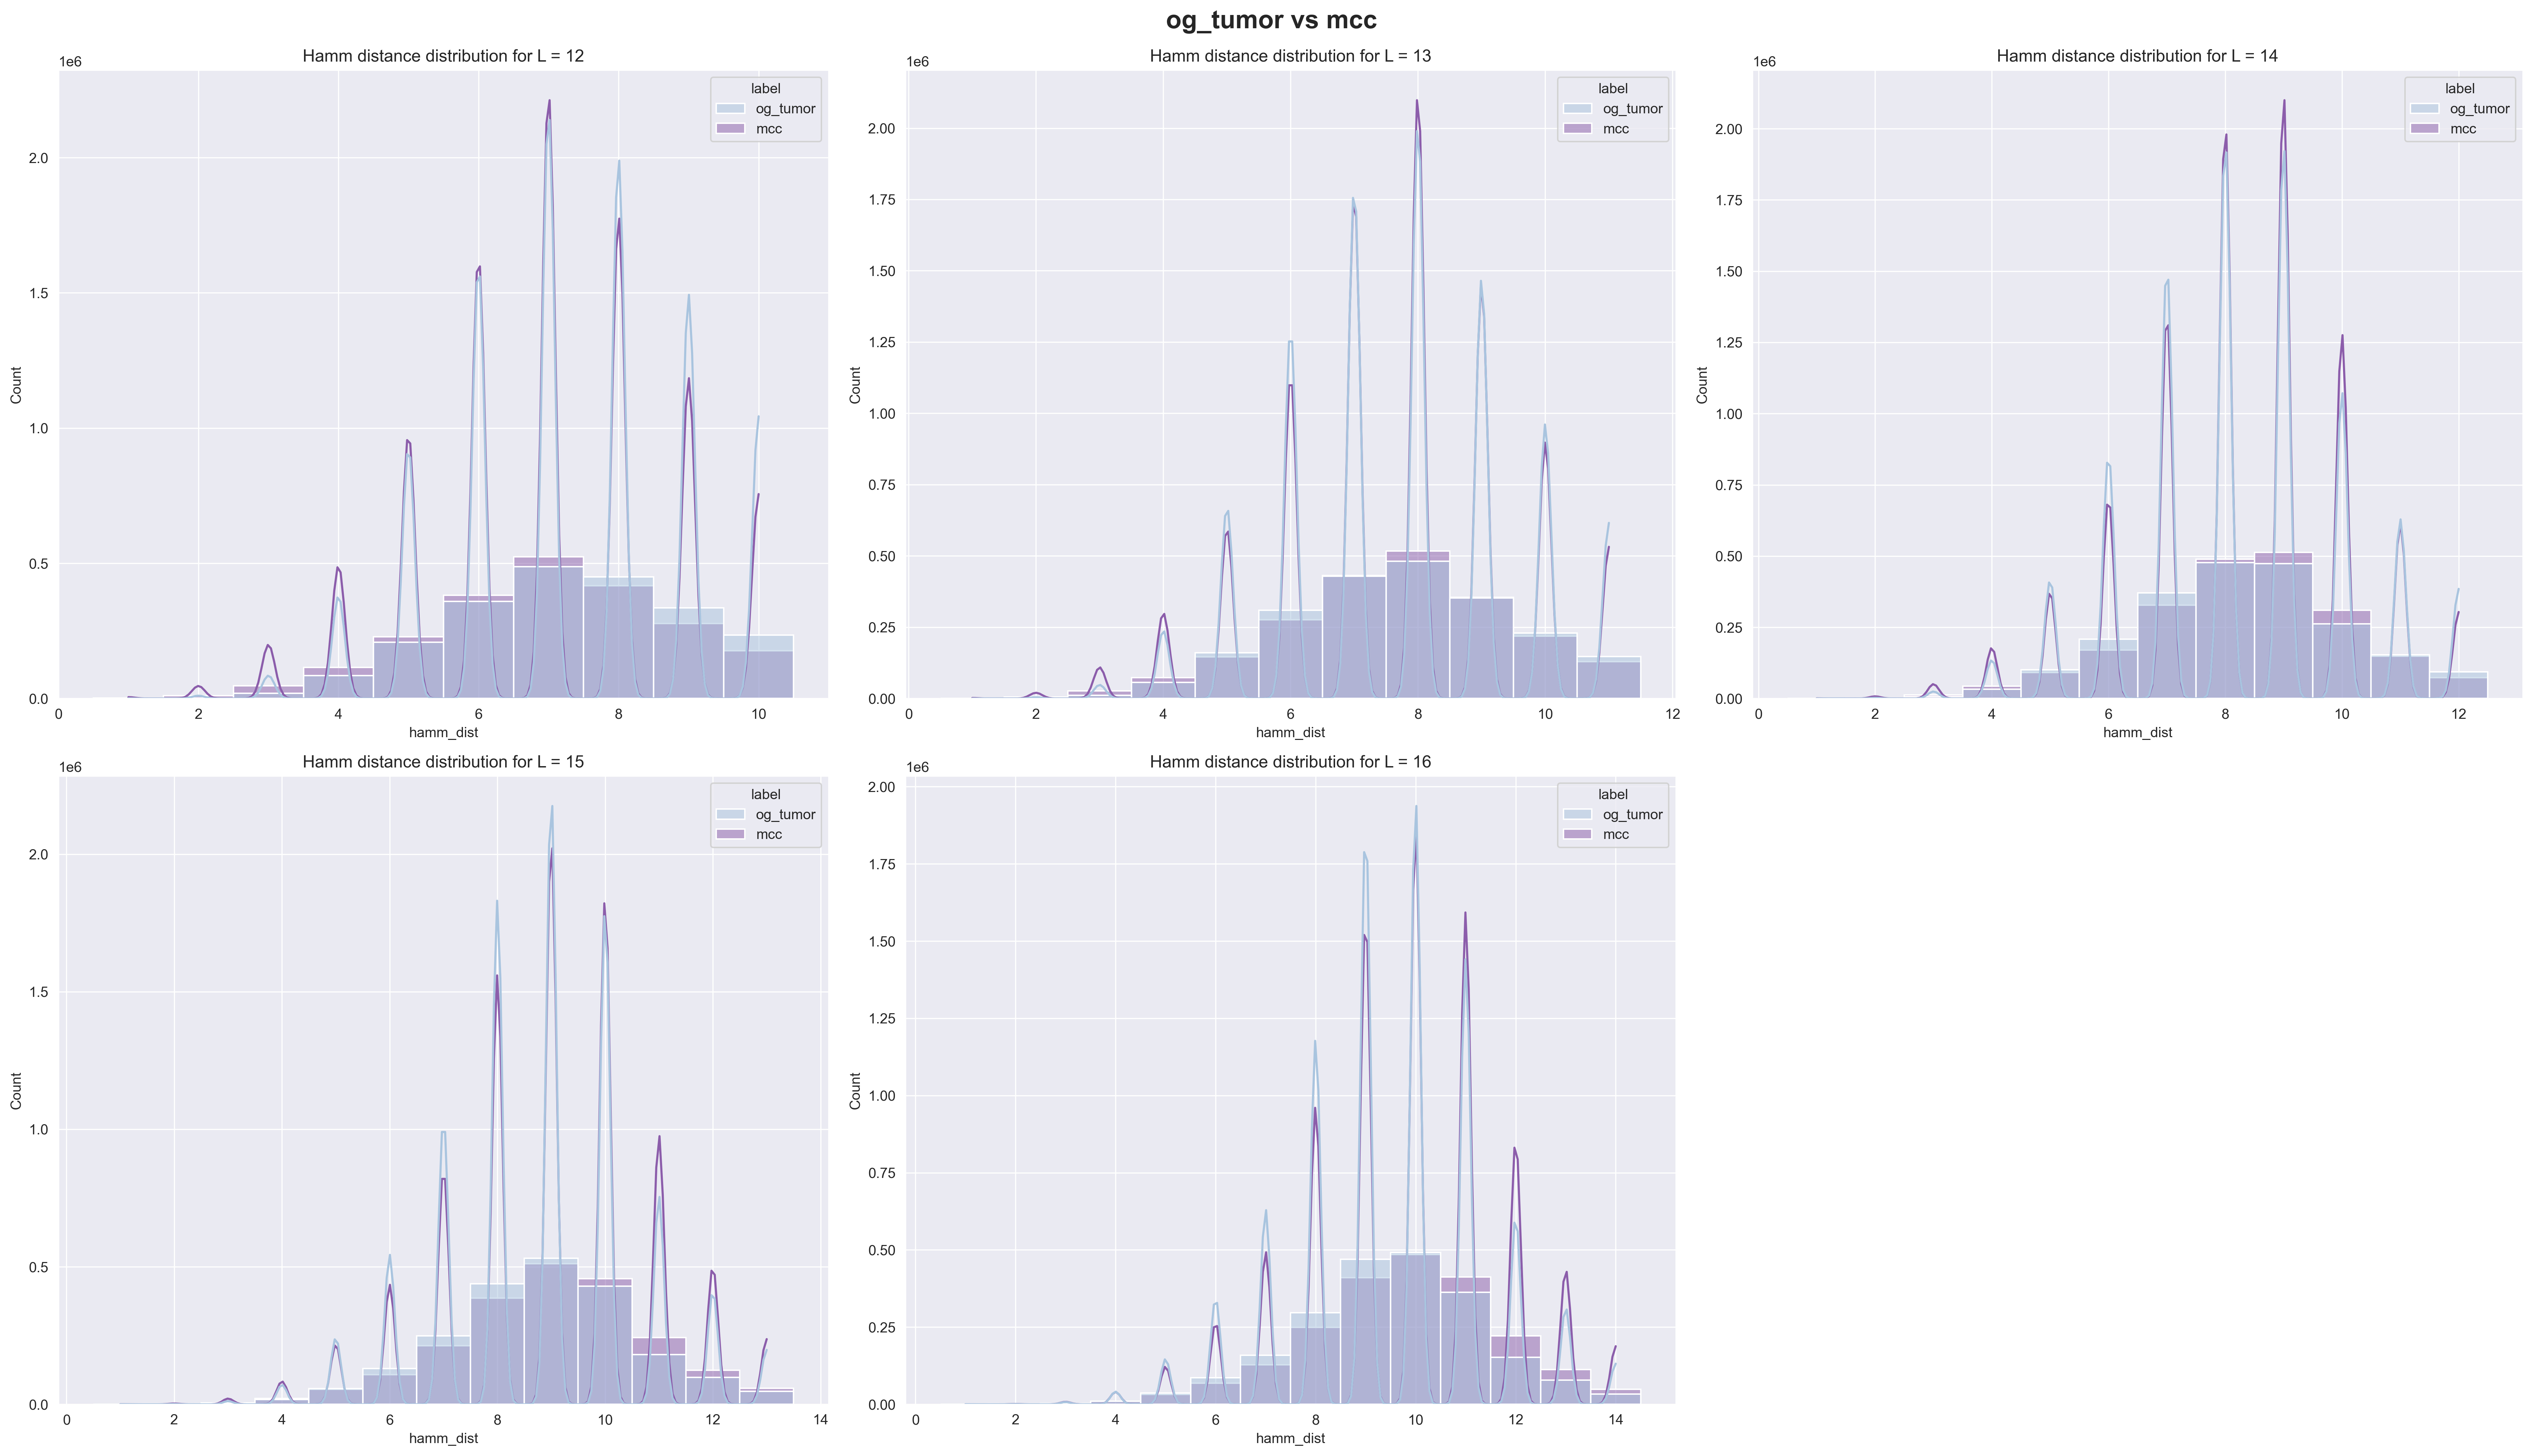

In [78]:
plot_hamm_dist(tumor_dists, 'og_tumor','mcc')

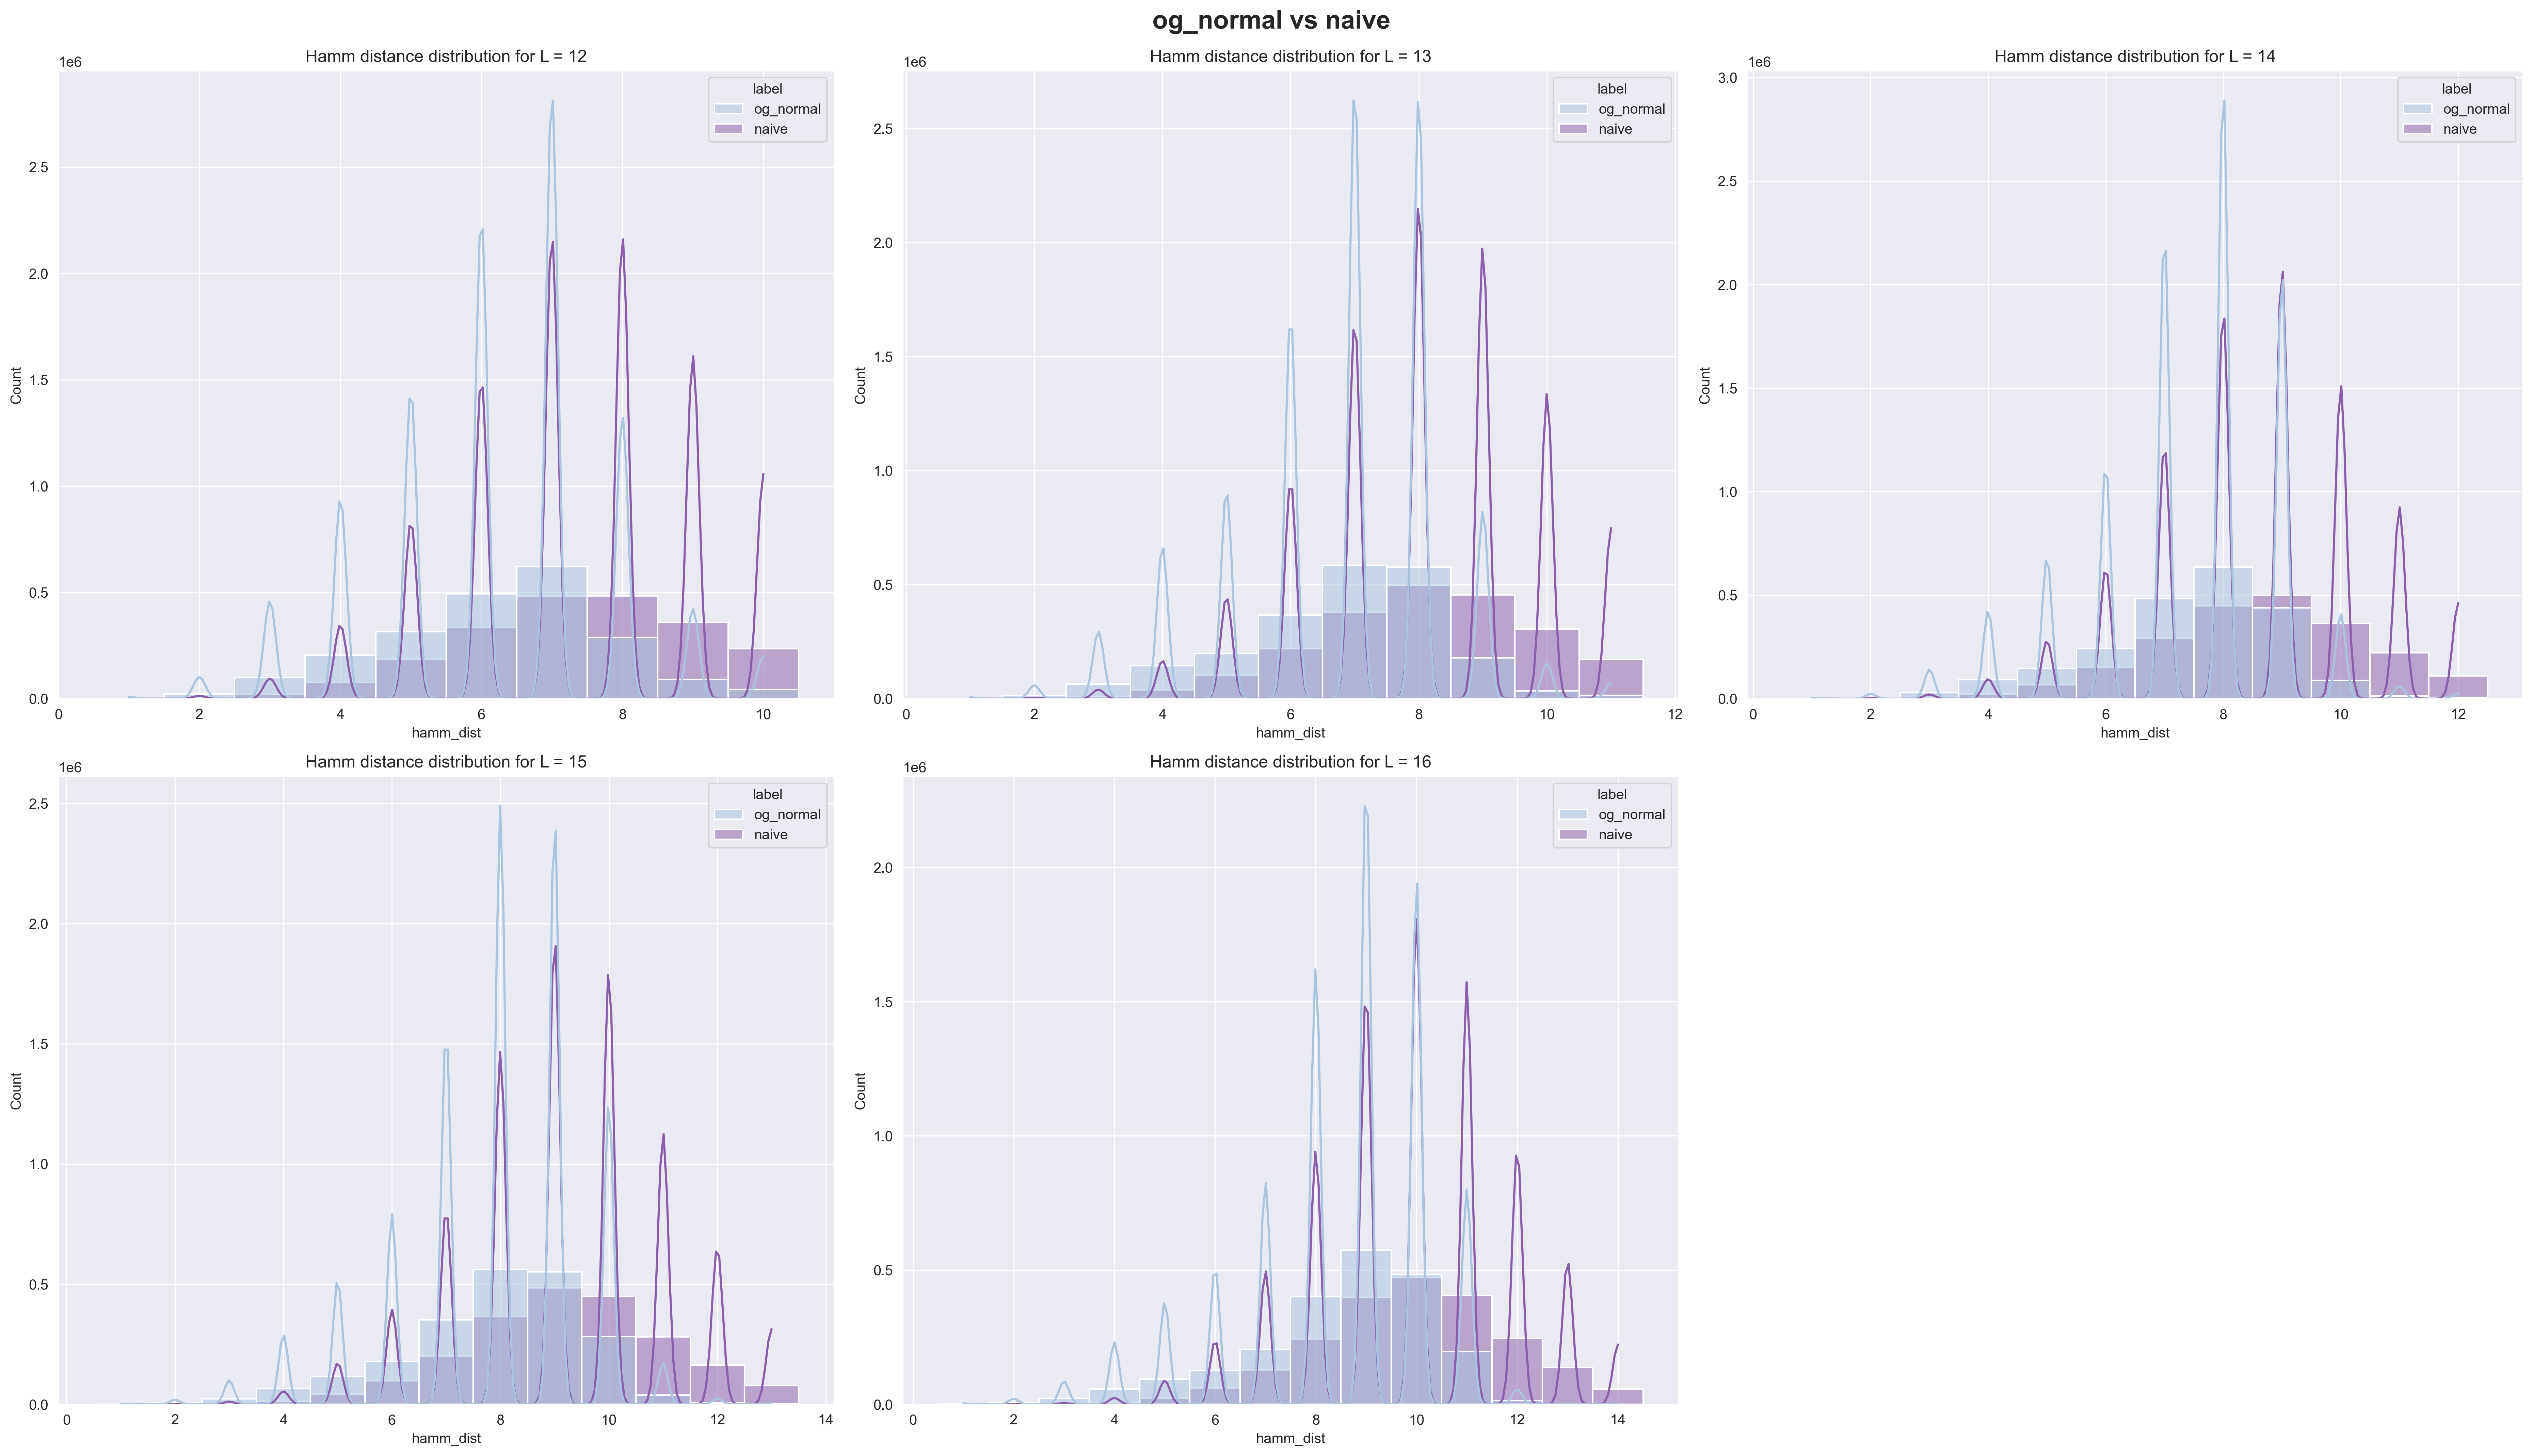

In [79]:
plot_hamm_dist(naive_dists, 'og_normal','naive')

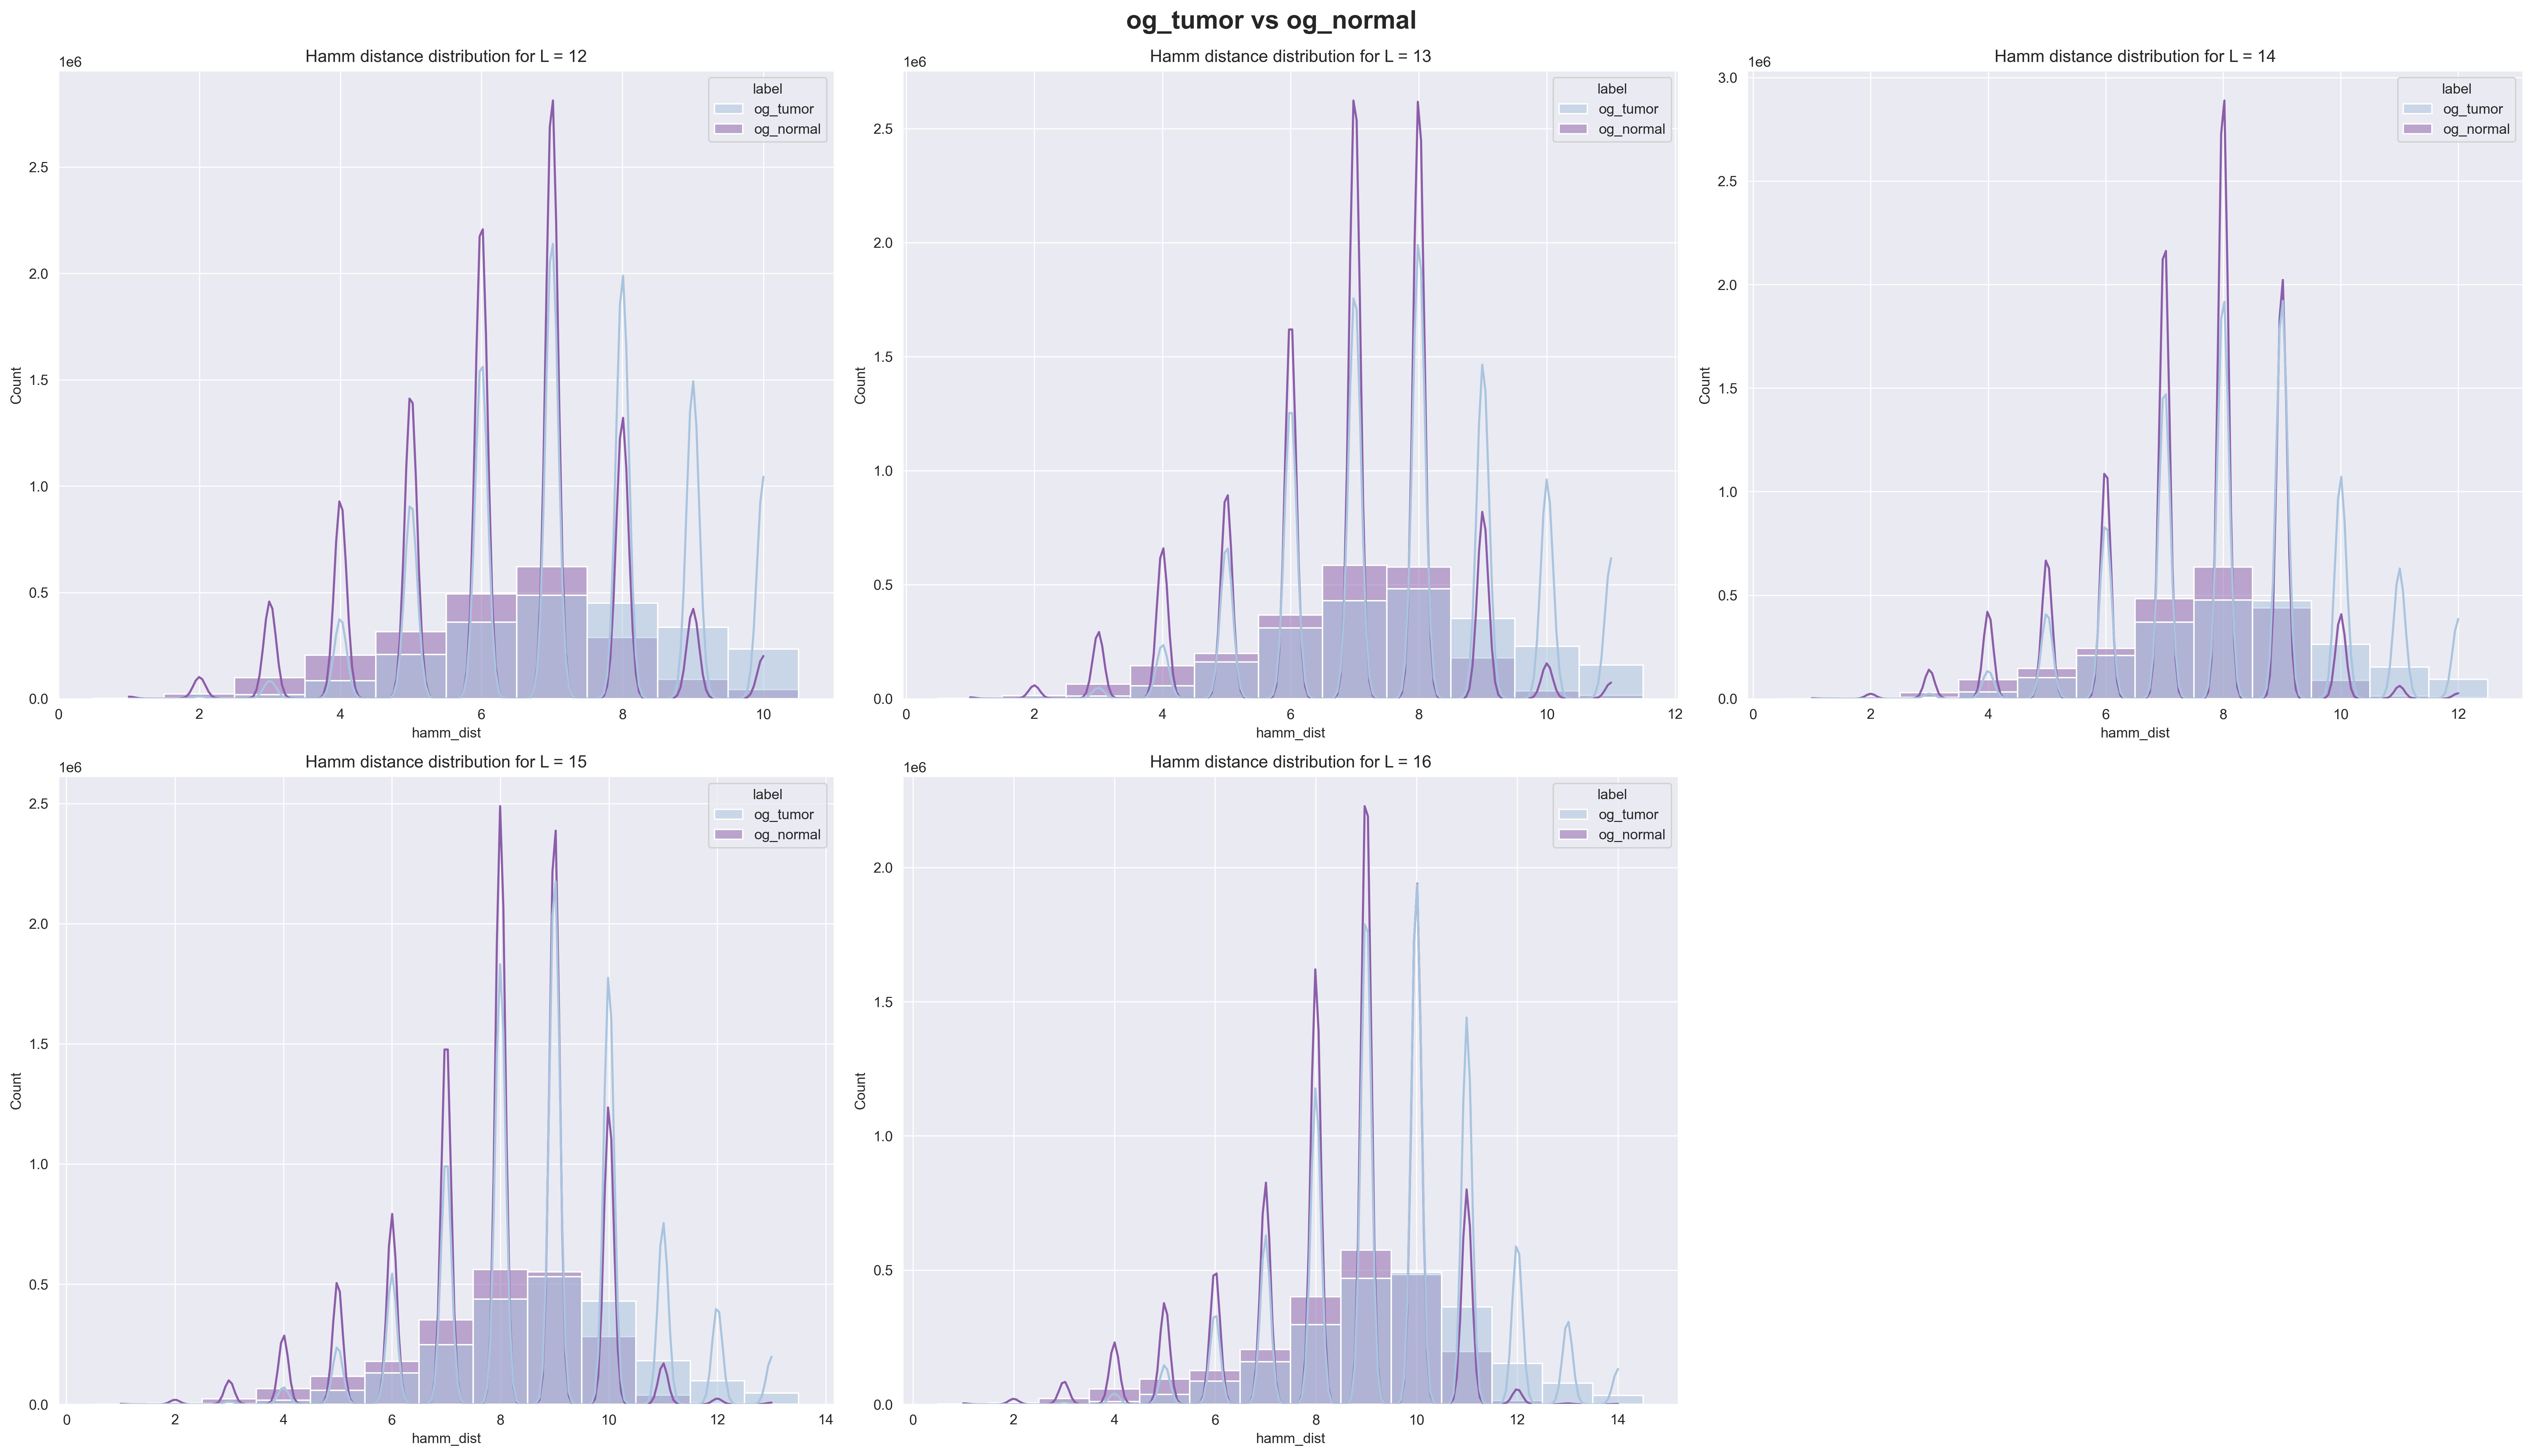

In [80]:
plot_hamm_dist(og, 'og_tumor','og_normal')

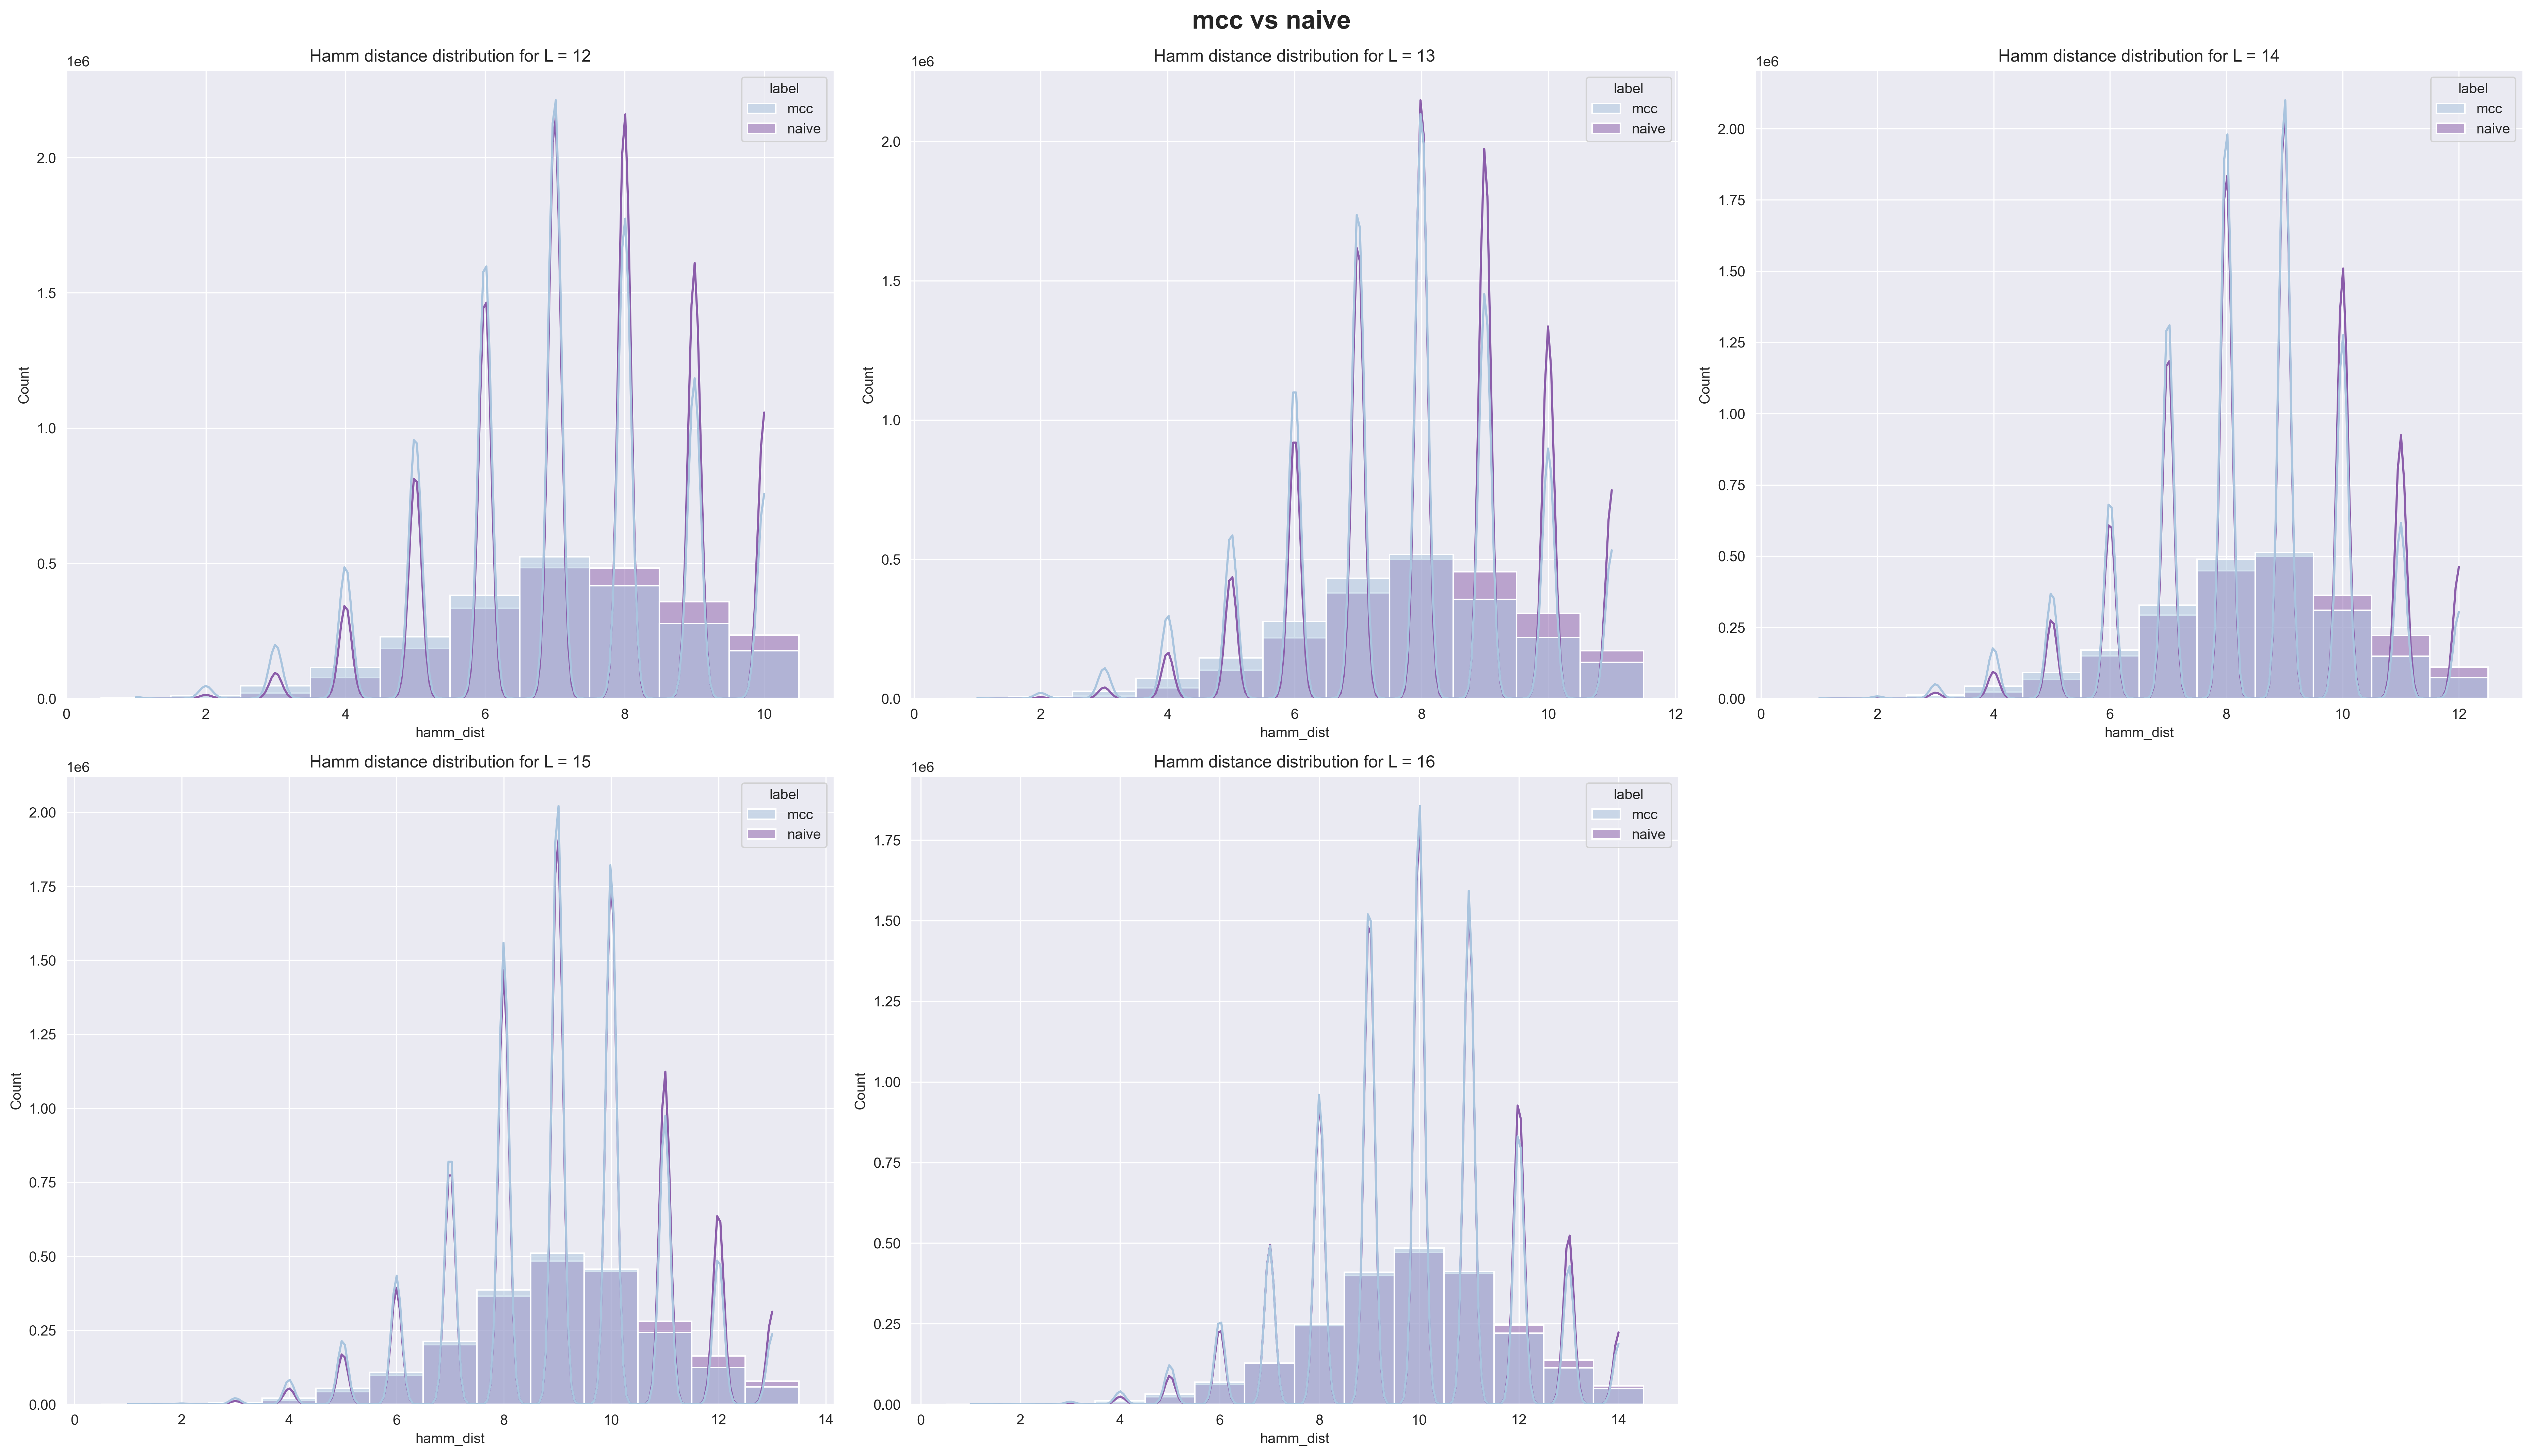

In [81]:
plot_hamm_dist(new, 'mcc','naive')